In [1]:
import xarray as xr
import sys
sys.path.insert(0, 'C:/Users/woorak choi/Desktop/rps-tigress/notebook')
#sys.path.insert(0, '/media/woorak/EEE2F3A4E2F36F69/Users/woorak choi/Desktop/rps-tigress/notebook') # for ubuntu
import pyathena.preprocessing as pre
import numpy as np
import matplotlib.pyplot as plt

In [21]:
base = 'G:/yeongu/'
#base = '/media/woorak/data2/yeongu/' # for ubuntu
pid='RPS_8pc_ICM2_newacc'
 
#pre.zprof_to_xarray(base,pid,pid,icm=True)
zpdset=pre.merge_xarray(base,pid,pid)
data=zpdset.to_array(dim='phase').to_dataset(dim='fields')
if pid!='RPS_8pc_noICM_newacc':
    zpdset_icm=pre.merge_xarray(base,pid,pid,icm=True)
    data_icm=zpdset_icm.to_array(dim='phase').to_dataset(dim='fields')

#dset.to_netcdf(base+pid+'/zprof_merged/'+pid+'.merged.nc')

In [3]:
import astropy.constants as c
import astropy.units as u
G = c.G.cgs.value
Msun = c.M_sun.cgs.value
pc = c.pc.cgs.value
pi = np.pi
m_unit = 1.4271*c.m_p.cgs.value*pc**3
l_unit = pc
v_unit = 1.e5
t_unit = l_unit/v_unit
G_code = (G/l_unit**3)*m_unit*t_unit**2
rho_unit = m_unit/l_unit**3

p_unit = rho_unit*v_unit**2
deltaz = data.zaxis.data[1]-data.zaxis.data[0]
kb = c.k_B.cgs.value
print(rho_unit, p_unit, pc, deltaz, kb)

(2.3869987106358e-24, 2.3869987106358e-14, 3.085677581467192e+18, 4, 1.38064852e-16)


In [4]:
phase=['warm','intermediate','hot','total']
#phase=['cold','unstable','warm','intermediate','hot']
color = ['C2','C1','C3','C0','C4','C5']
Plabel =[r'$\langle P_{th}\rangle$',r'$\langle P_{\rm turb,z}\rangle$',r'$\langle \Pi_{\rm mag}\rangle$'] 
linestyle = ['-','--',':','-.']

In [5]:
from matplotlib.ticker import MultipleLocator

def get_flux_weight(data_,t1,t2,area):
    zaxis=data_.zaxis
    zmax=zaxis.max().data
    hNz=int(len(zaxis)/2)

    # set pressures within the time range
    Pth=data_.sel(fields='P',taxis=slice(t1,t2))
    Pturb=2.0*data_.sel(fields='Ek3',taxis=slice(t1,t2))
    Pmag=data_.sel(fields=['PB1','PB2','PB3']).sum(dim='fields')-data_.sel(fields=['PB3']).sum(dim='fields')*2.0
    Pmag=Pmag.sel(taxis=slice(t1,t2))
    
    # time average of total momentum flux
    totFlux=((Pth+Pturb+Pmag)*p_unit/area).mean(dim='taxis')
    
    if pid=='RPS_8pc_noICM_newacc':
        # split upper and lower planes to apply different reference values 
        totFlux_u = totFlux.sel(zaxis=slice(0,zmax))
        totFlux_u-= totFlux.sel(zaxis=zmax,method='nearest')
        totFlux_l = totFlux.sel(zaxis=slice(-zmax,0))
        totFlux_l-= totFlux.sel(zaxis=-zmax,method='nearest')

        # concatenate back to a single array
        totFlux=xr.concat([totFlux_l,totFlux_u],dim='zaxis')
        
        # split upper and lower plances to apply different integration range
        # note that dWext and dWsg fields are rho*g_{z,ext/sg}
        # upper: zmax to z -- need to reverse the array
        # lower: zmin to z
        dWext_u=data_.sel(fields='dWext',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(0,1.e4))
        dWext_u=dWext_u.reindex(zaxis=dWext_u.zaxis[::-1])
        dWext_l=-data_.sel(fields='dWext',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(-1.e4,0))
        
        Wext_l=dWext_l.cumsum(dim='zaxis')
        Wext_u=dWext_u.cumsum(dim='zaxis')
        Wext_u=Wext_u.reindex(zaxis=Wext_u.zaxis[::-1])
        # multiply dz for integration
        Wext=xr.concat([Wext_l,Wext_u],dim='zaxis')*deltaz*p_unit/area

        # same calculation for the self gravity term
        dWsg_u=data_.sel(fields='dWsg',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(0,1.e4))
        dWsg_u=dWsg_u.reindex(zaxis=dWsg_u.zaxis[::-1])
        dWsg_l=-data_.sel(fields='dWsg',taxis=slice(t1,t2)).mean(dim='taxis').sel(zaxis=slice(-1.e4,0))
        
        Wsg_l=dWsg_l.cumsum(dim='zaxis')
        Wsg_u=dWsg_u.cumsum(dim='zaxis')
        Wsg_u=Wsg_u.reindex(zaxis=Wsg_u.zaxis[::-1])
        Wsg=xr.concat([Wsg_l,Wsg_u],dim='zaxis')*deltaz*p_unit/area
        
        Weight=Wext+Wsg
        
    else:
        
        totFlux -=totFlux.sel(zaxis=zmax,method='nearest')
    
        dWext=data_.sel(fields='dWext',taxis=slice(t1,t2)).mean(dim='taxis')
        dWext=dWext.reindex(zaxis=dWext.zaxis[::-1])
        Wext=dWext.cumsum(dim='zaxis')
        Wext=Wext.reindex(zaxis=Wext.zaxis[::-1])*deltaz*p_unit/area

        dWsg=data_.sel(fields='dWsg',taxis=slice(t1,t2)).mean(dim='taxis')
        dWsg=dWsg.reindex(zaxis=dWsg.zaxis[::-1])
        Wsg=dWsg.cumsum(dim='zaxis')
        Wsg=Wsg.reindex(zaxis=Wsg.zaxis[::-1])*deltaz*p_unit/area

        Weight=Wext+Wsg
    
    return totFlux,Weight,Wext,Wsg

250


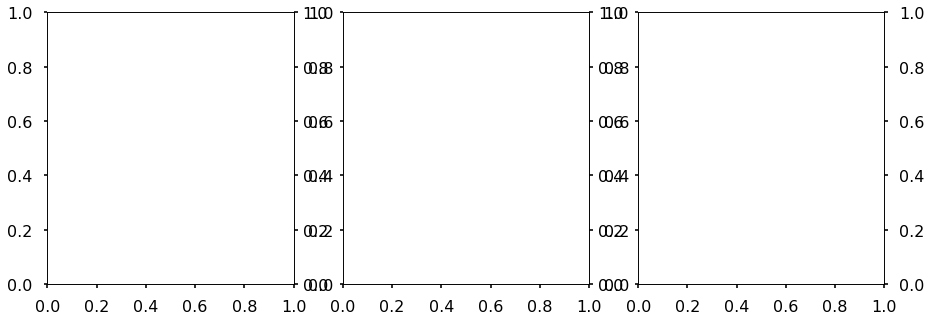

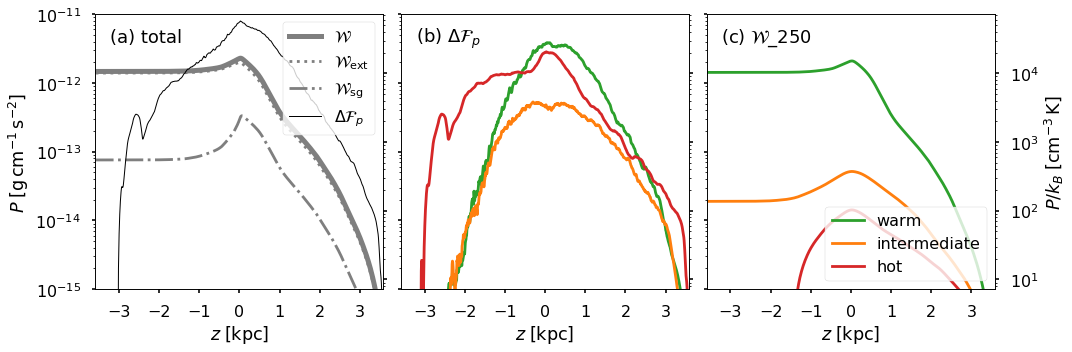

280


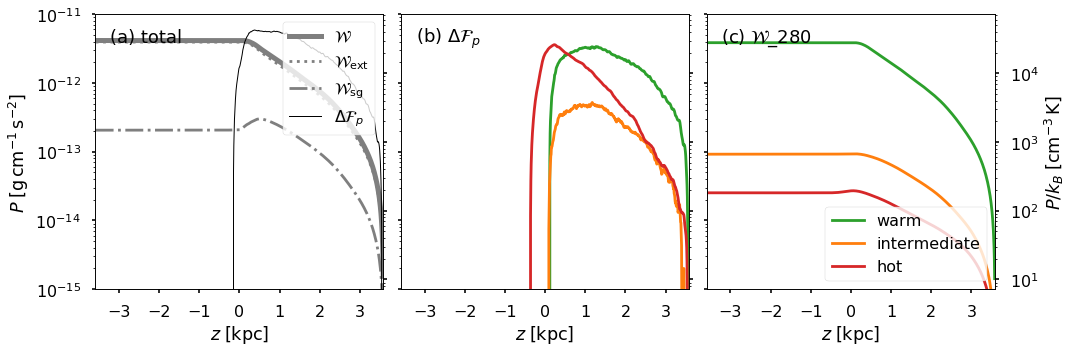

310


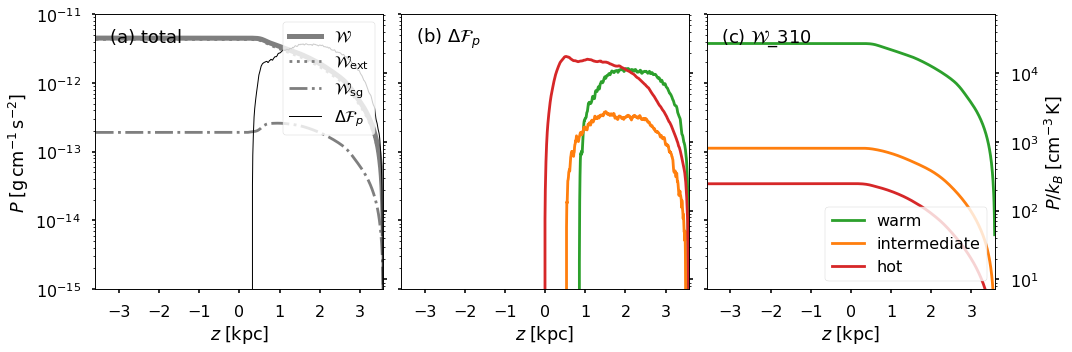

340


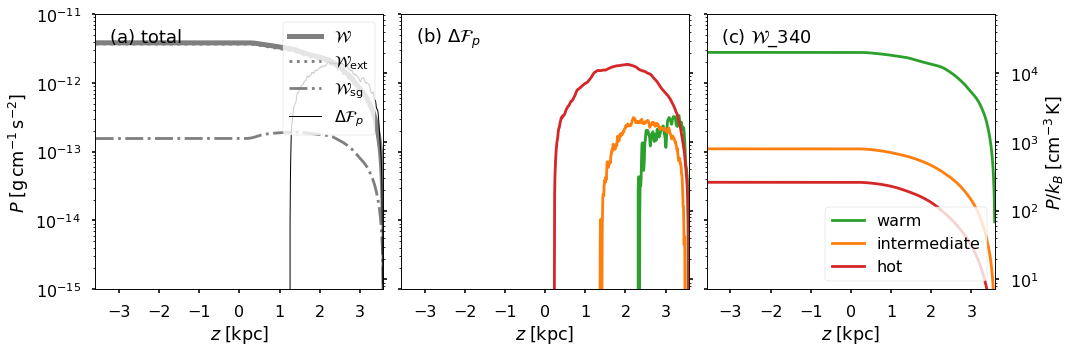

370


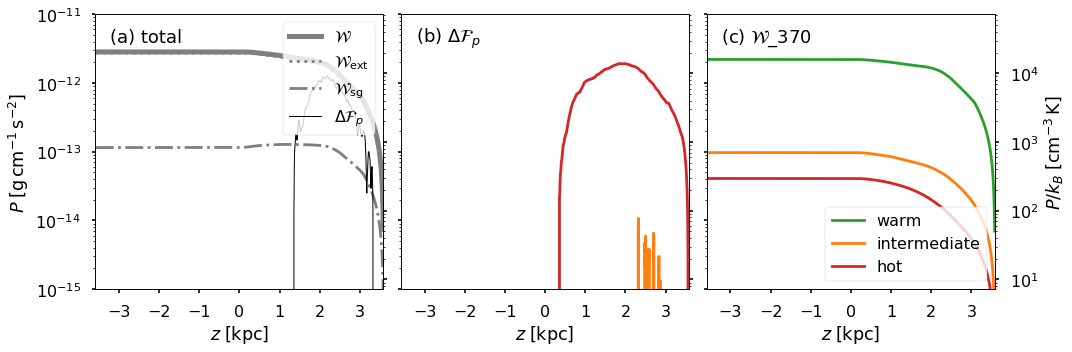

400


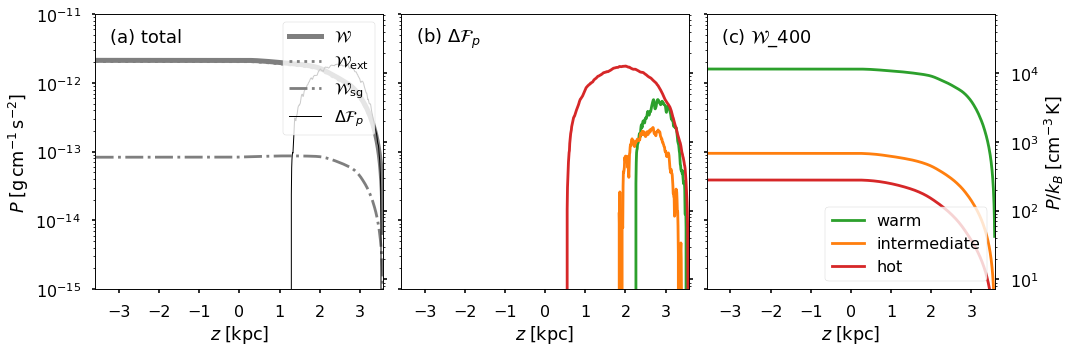

430


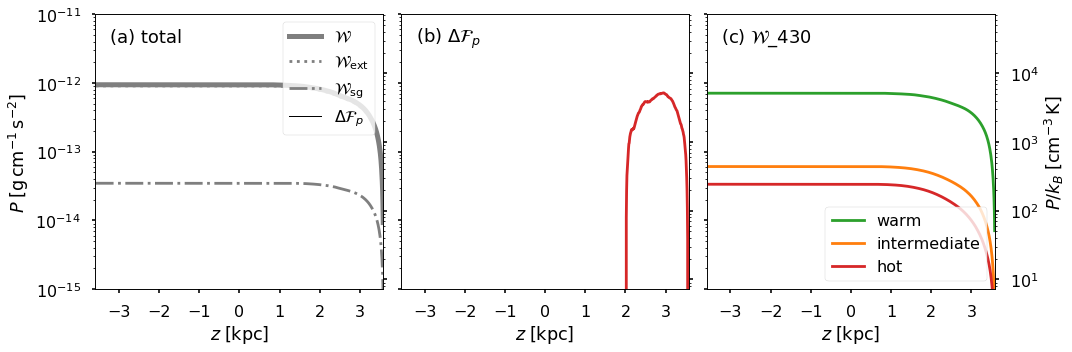

460


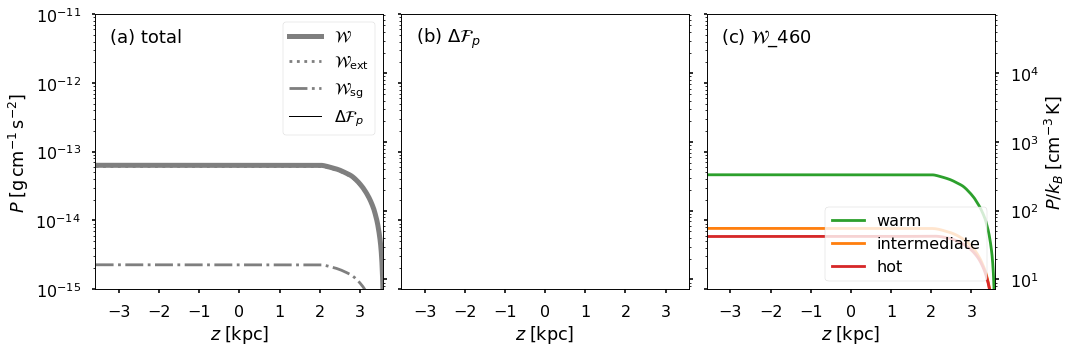

490


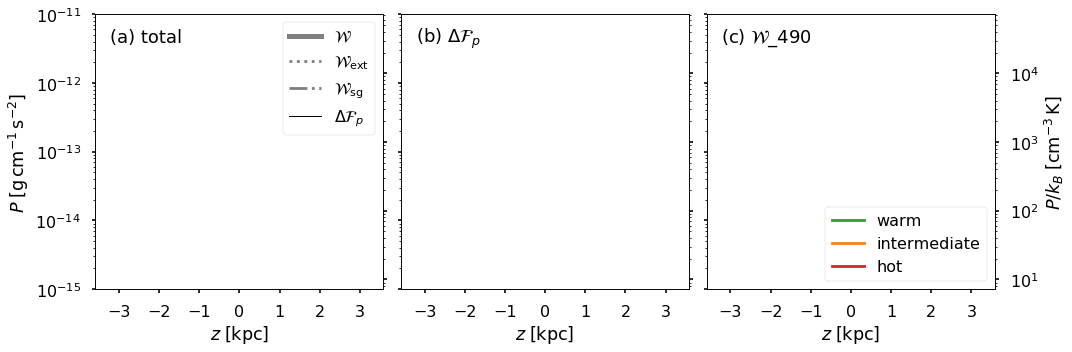

In [22]:
with plt.style.context('seaborn-poster'):

    # setup figures
    for k in range(0,250,30):
        t1 = k+250
        t2 = t1+30
        f, ax = plt.subplots(1,3, figsize=(15,5))
        ax=ax.flatten()
        axi = []
        for j in range(3): axi = np.append(axi, ax[j].twinx())    

        # comparison between weight and momentum flux (pressure)

        ax_= ax[0]
        data_ = data.sum(dim='phase').to_array(dim='fields')
        #print data_
        totarea=float(data_.sel(fields='A')[0,0])
        #print totarea
        F,W,We,Ws = get_flux_weight(data_,t1,t2,area=totarea)

        data_ = data_icm.sum(dim='phase').to_array(dim='fields')
        totarea=float(data_.sel(fields='A')[0,1])
        F_icm,W_icm,We_icm,Ws_icm = get_flux_weight(data_,t1,t2,area=totarea)


        ax_.plot(data_.zaxis/1.e3,W-W_icm,ls='-',color='C7',lw=5,label=r'$\mathcal{W}$')
        ax_.plot(data_.zaxis/1.e3,We-We_icm,ls=':',color='C7',label=r'$\mathcal{W}_{\rm ext}$')
        ax_.plot(data_.zaxis/1.e3,Ws-Ws_icm,ls='-.',color='C7',label=r'$\mathcal{W}_{\rm sg}$')
        ax_.plot(data_.zaxis/1.e3,F-F_icm,ls='-',color='k',lw=1,label=r'$\Delta \mathcal{F}_p$')

        # momentum fluxes for each phase
        ax_= ax[1]
        for i in [0,1,2]:
            data_ = data.isel(phase=i+2).to_array(dim='fields')
            F,W,We,Ws = get_flux_weight(data_,t1,t2,area=totarea)

            data_ = data_icm.isel(phase=i+2).to_array(dim='fields')
            F_icm,W_icm,We_icm,Ws_icm = get_flux_weight(data_,t1,t2,area=totarea)

            #print 'Flux',phase[i],float(F.max()/kb)
            ax_.plot(data_.zaxis/1.e3,F-F_icm,ls='-',color=color[i])

        # weights for each phase    
        ax_= ax[2]
        for i in [0,1,2]:
            data_ = data.isel(phase=i+2).to_array(dim='fields')
            F,W,We,Ws = get_flux_weight(data_,t1,t2,area=totarea)
            #print 'Weight',phase[i],float(W.max()/kb)

            data_ = data_icm.isel(phase=i+2).to_array(dim='fields')
            F_icm,W_icm,We_icm,Ws_icm = get_flux_weight(data_,t1,t2,area=totarea)

            ax_.plot(data_.zaxis/1.e3,W-W_icm,ls='-',color=color[i],label=phase[i])

        # cosmetics
        plt.setp([ax,axi],'yscale','log')
        plt.setp(ax,'xticks',np.arange(-3.,3.5,1.))
        plt.setp(ax,'ylim',(1.e-15,1.e-11))
        plt.setp(axi,'ylim',(1.e-15/kb, 1.e-11/kb))
        plt.setp(ax,'xlim',(-3.584,3.584))
        plt.setp(ax,'xlabel',r'$z\;[{\rm kpc}]$')

        plt.setp([ax_.get_yticklabels() for ax_ in ax[1:]],visible=False)
        plt.setp([ax_.get_yticklabels() for ax_ in axi[:-1]],visible=False)

        ax[0].set_ylabel(r'$P\;[{\rm g\,cm^{-1}\,s^{-2}}]$')
        axi[2].set_ylabel(r'$P/k_B\;[{\rm cm^{-3}\,K}]$')
        ax[0].legend(loc='upper right')
        ax[2].legend(loc='lower right')

        for ax_,plabel in zip(ax,[r'(a) total',r'(b) $\Delta \mathcal{F}_p$',r'(c) $\mathcal{W}$_%s' % t1]):
            ax_.text(0.05,0.9,plabel,transform=ax_.transAxes,fontsize=18)
        plt.tight_layout()
        #plt.savefig("D:/yeongu/plots/profile_movie/profile_new/%s_%s_ism_only.png" % (pid,t1),bbox_inches='tight')#,dpi=100)
        print t1
        plt.show()

In [28]:
base = 'G:/yeongu/'
#base = '/media/woorak/data2/yeongu/' # for ubuntu
pid='RPS_8pc_ICM1_newacc'
 
#pre.zprof_to_xarray(base,pid,pid,icm=True)
zpdset=pre.merge_xarray(base,pid,pid)
data=zpdset.to_array(dim='phase').to_dataset(dim='fields')
if pid!='RPS_8pc_noICM_newacc':
    zpdset_icm=pre.merge_xarray(base,pid,pid,icm=True)
    data_icm=zpdset_icm.to_array(dim='phase').to_dataset(dim='fields')

#dset.to_netcdf(base+pid+'/zprof_merged/'+pid+'.merged.nc')

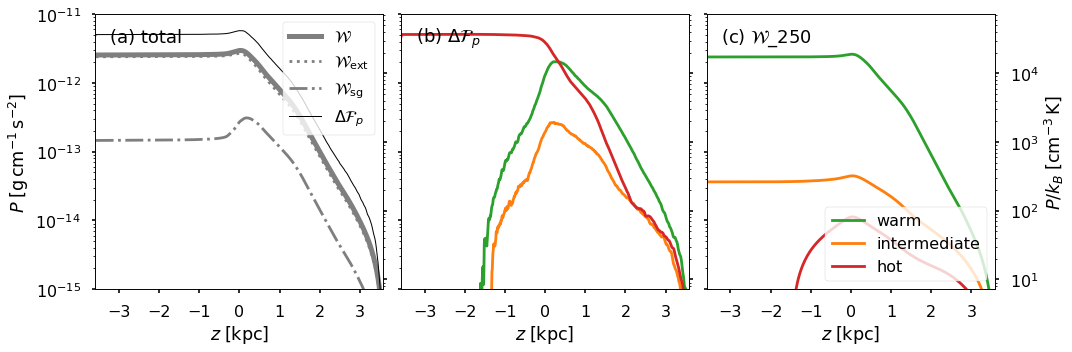

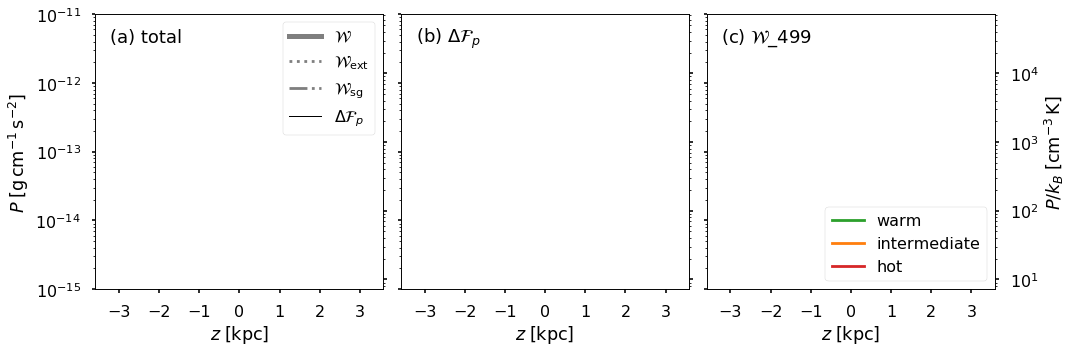

In [29]:
with plt.style.context('seaborn-poster'):

    # setup figures
    #data_icm=np.array(0)
    W_icm=0; We_icm=0; Ws_icm=0;F_icm=0
    for k in range(0,250,249):
        t1 = k+250
        t2 = t1+249
        f, ax = plt.subplots(1,3, figsize=(15,5))
        ax=ax.flatten()
        axi = []
        for j in range(3): axi = np.append(axi, ax[j].twinx())    

        # comparison between weight and momentum flux (pressure)

        ax_= ax[0]
        data_ = data.sum(dim='phase').to_array(dim='fields')
        #print data_
        totarea=float(data_.sel(fields='A')[0,0])
        #print totarea
        F,W,We,Ws = get_flux_weight(data_,t1,t2,area=totarea)

        data_ = data_icm.sum(dim='phase').to_array(dim='fields')
        totarea=float(data_.sel(fields='A')[0,1])
        #F_icm,W_icm,We_icm,Ws_icm = get_flux_weight(data_,t1,t2,area=totarea)


        ax_.plot(data_.zaxis/1.e3,W-W_icm,ls='-',color='C7',lw=5,label=r'$\mathcal{W}$')
        ax_.plot(data_.zaxis/1.e3,We-We_icm,ls=':',color='C7',label=r'$\mathcal{W}_{\rm ext}$')
        ax_.plot(data_.zaxis/1.e3,Ws-Ws_icm,ls='-.',color='C7',label=r'$\mathcal{W}_{\rm sg}$')
        ax_.plot(data_.zaxis/1.e3,F-F_icm,ls='-',color='k',lw=1,label=r'$\Delta \mathcal{F}_p$')

        # momentum fluxes for each phase
        ax_= ax[1]
        for i in [0,1,2]:
            data_ = data.isel(phase=i+2).to_array(dim='fields')
            F,W,We,Ws = get_flux_weight(data_,t1,t2,area=totarea)

            data_ = data_icm.isel(phase=i+2).to_array(dim='fields')
            #F_icm,W_icm,We_icm,Ws_icm = get_flux_weight(data_,t1,t2,area=totarea)

            #print 'Flux',phase[i],float(F.max()/kb)
            ax_.plot(data_.zaxis/1.e3,F-F_icm,ls='-',color=color[i])

        # weights for each phase    
        ax_= ax[2]
        for i in [0,1,2]:
            data_ = data.isel(phase=i+2).to_array(dim='fields')
            F,W,We,Ws = get_flux_weight(data_,t1,t2,area=totarea)
            #print 'Weight',phase[i],float(W.max()/kb)

            data_ = data_icm.isel(phase=i+2).to_array(dim='fields')
            #F_icm,W_icm,We_icm,Ws_icm = get_flux_weight(data_,t1,t2,area=totarea)

            ax_.plot(data_.zaxis/1.e3,W-W_icm,ls='-',color=color[i],label=phase[i])

        # cosmetics
        plt.setp([ax,axi],'yscale','log')
        plt.setp(ax,'xticks',np.arange(-3.,3.5,1.))
        plt.setp(ax,'ylim',(1.e-15,1.e-11))
        plt.setp(axi,'ylim',(1.e-15/kb, 1.e-11/kb))
        plt.setp(ax,'xlim',(-3.584,3.584))
        plt.setp(ax,'xlabel',r'$z\;[{\rm kpc}]$')

        plt.setp([ax_.get_yticklabels() for ax_ in ax[1:]],visible=False)
        plt.setp([ax_.get_yticklabels() for ax_ in axi[:-1]],visible=False)

        ax[0].set_ylabel(r'$P\;[{\rm g\,cm^{-1}\,s^{-2}}]$')
        axi[2].set_ylabel(r'$P/k_B\;[{\rm cm^{-3}\,K}]$')
        ax[0].legend(loc='upper right')
        ax[2].legend(loc='lower right')

        for ax_,plabel in zip(ax,[r'(a) total',r'(b) $\Delta \mathcal{F}_p$',r'(c) $\mathcal{W}$_%s' % t1]):
            ax_.text(0.05,0.9,plabel,transform=ax_.transAxes,fontsize=18)
        plt.tight_layout()
        #plt.savefig("D:/yeongu/plots/profile_movie/profile_new/%s_%s_ism_only.png" % (pid,t1),bbox_inches='tight')#,dpi=100)
        #print t1
        plt.show()